# Fundamentals of Computer Vision: Applied Projects


This Jupyter notebook contains the bases of the projects you need to develop during the semester.

The main goal of this project is twofold: 1st is to reiterate the theoretical context of the lectures and 2nd to use those methods in adapted examples for real-world scenarios.

---

## Import libraries, util functions and test image loading



In [131]:
# Importing working libraries
import os
import cv2
import urllib3
import numpy as np
from PIL import Image
from typing import List, Tuple
from scipy.ndimage import convolve
from matplotlib import pyplot as plt

# Select your development environment
environment = "Google Colab" # "Google Colab", "Local"

# Loading depending on environment
lab3_path = ""
if environment == "Google Colab":
  from google.colab import drive
  from google.colab.patches import cv2_imshow
  # Import from my google drive
  drive.mount('/content/drive')
  lab3_path = "/content/drive/MyDrive/Colab Notebooks/UAB Project/Computer Vision/UAB23-Computer-Vision-Labs/Lab 3"
else:
  lab3_path = "./"

# Load images path
path_images = os.path.join(lab3_path,"images")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Block 3. Segmentation as region classifiers

## List of segmentation algorithms by type

### Threshold-Based Segmentation (Mandatory. Implement by hand / Extend from previous labs)
- **Global Thresholding**: Applies a single threshold value across the entire image to separate objects from the background.
- **Adaptive Mean Thresholding**: Computes thresholds for different regions of the image based on mean values to handle varying lighting conditions.
- **Otsu's Thresholding**: Calculates an optimal threshold value that minimizes intra-class variance, or equivalently, maximizes inter-class variance.

### Edge-Based Segmentation (Mandatory. Implement by hand / Extend from previous labs)
- **Sobel Operator**: Detects edges using a pair of 3x3 convolution kernels, one for horizontal changes, and one for vertical.
- **Canny Edge Detector**: A multi-stage algorithm that includes noise reduction, gradient calculation, non-maximum suppression, and edge tracking by hysteresis.
- **Laplacian of Gaussian (LoG)**: Applies a Gaussian blur to smooth the image before computing the Laplacian for edge detection, capturing blobs and edges.

### Watershed-Based Segmentation (Mandatory. Use OpenCV implementation)
- **Watershed Algorithm**: Treats the gradient magnitude of an image as a topographic surface and finds watershed lines to segment the image based on catchment basins.

### Region-Based Segmentation (Choose 1. Implement by hand. Can make use of scikit-image library)
- **Split-and-Merge**: This technique recursively splits an image into regions based on a homogeneity criterion and then merges adjacent regions that have similar properties.
- **Flood Fill**: Also known as seed fill, this method starts from a seed point and grows a region by adding neighboring pixels that are similar to the seed.
Represents an image as a graph, where nodes correspond to segments and edges represent adjacency between segments, then merges nodes based on similarity measures.

### Clustering-Based Segmentation (Only analysis)
- **K-means Clustering**: Partitions the image into clusters based on pixel color or intensity, with the number of clusters predefined.
- **Gaussian Mixture Models (GMM)**: Uses a probabilistic model to represent normally distributed subpopulations within the overall population, providing a soft-segmentation of the image.


### List of ideas for improving some methods results
---

### Threshold-Based Segmentation

Global Thresholding:
1. Implement histogram analysis to automatically select a better global threshold.
2. Experiment with different global thresholds and evaluate the results using entropy-based or region-based metrics.

Adaptive Mean Thresholding:
1. Explore the use of different shapes and sizes for the local neighborhood when computing the mean value.
2. Combine with a preprocessing step that performs histogram equalization to enhance contrast before thresholding.

Otsu's Thresholding:
1. Extend Otsu's method to work with multi-level thresholds instead of just bi-level thresholds.


### Edge-Based Segmentation

Canny Edge Detector:
1. Optimize the selection of low and high threshold values using the median of the gradient magnitudes.
2. Implement an automated hysteresis process that adapts to the edge strength histogram of the image.

Laplacian of Gaussian (LoG):
1. Experiment with scale-space representation by varying the standard deviation of the Gaussian filter.
2. Automate the selection of the Gaussian kernel size based on the analysis of the image frequencies.

### Watershed-Based Segmentation

Watershed Algorithm:
1. Implement pre-processing steps to reduce noise, such as morphological operations, before applying the watershed.
2. Use marker-based watershed segmentation, where markers are determined automatically through morphological operations or distance transformation.

### Region-Based Segmentation

Split-and-Merge (RAG):
1. Incorporate texture or color gradients as additional criteria for deciding splits or merges, enhancing the segmentation for complex scenes.

Flood Fill:
1. Develop an adaptive flood fill algorithm where the tolerance level for pixel similarity is determined based on local image statistics.
2. Integrate edge detection results to guide the flood fill process, preventing it from crossing likely boundaries.


## Mandatory Questions

#### Threshold-Based Segmentation
1. Explain the basic concept of global thresholding. How is a single threshold value determined and applied across the entire image?
2. In what scenarios is adaptive mean thresholding more effective than global thresholding?
3. Describe Otsu's thresholding method in detail. How does it compute an optimal threshold value, and what makes it different from simple global thresholding?

#### Edge-Based Segmentation
4. Describe how the Sobel operator works. What are the roles of its horizontal and vertical kernels?

	The Sobel operator is oriented to find the intensity gradient of a given image; that is, the points where the intensity of the image changes abruptly. Ideally, these points of abrupt change will also be the contours of the image, therefore, the Sobel operator will help us to detect them.
	To achieve this, since we cannot derive the values contained in the image pixels, as these are not applicable to spatial derivatives for which standard methods of calculation are used, we will use convolution as a tool applicable to this type of problem.
	We will convolve our image with two different kernels, one oriented to highlight the horizontal changes of intensity and the other for the vertical ones; this is achieved by defining three parallel regions in the kernel, the central one will have no contribution to the result because it is defined with zeros, the lateral regions to the central one will have negative and positive values respectively, being the midpoints of these lateral regions usually larger in magnitude.

		Sobelx = [-1, 0, 1]
			[-2, 0, 2]
			[-1, 0, 1]

		Sobely = [-1, -2, -1]
			[ 0, 0, 0]
			[ 1, 2, 1]

	With the kernel arrangement described, it is intended that, when being in a pixel with large intensity variation, the convolution operation increases the pixel intensity; on the other hand, when being in a pixel without intensity variation, the convolution attenuates its current intensity; therefore, the contrasts are maximized and the contours are defined.
	From the application of each of these convolutions we will obtain a component (Gx = Image * Sobelx, Gy = Image * Sobely), which can be combined to obtain the final gradient (G = sqrt(Gx^2 + Gy^2)) as well as its direction (theta = atan(Gx / Gy)).

5. Explain the steps involved in the Canny Edge Detector algorithm.

The Canny edge detector algorithm consists of five stages, each of which transforms in some specific way the image we are dealing with. These stages are:

- Gaussian Blur: the original image I, is subjected to the Gaussian Blur process, with a specific Gaussian kernel size and sigma value. Through this transformation we can get rid of the most prominent noise in the image, smoothing and preparing it for the subsequent process of region identification.
- Sobel edge detection: The Sobel algorithm is mainly intended to obtain the gradient of the image, thus, by applying the horizontal and vertical Sobel kernels, we can obtain both the gradient matrix and the Theta values, necessary for the application of the next stage.
- Non-Max Suppression: In order to keep only the maximum intensity values given the direction and magnitude of the gradient vector obtained from the application of the Sobel Edge Detector, Non-Max Suppression seeks to suppress all non-maximum intensities at all points of the image, managing to keep only the most prominent intensity changes that, in most cases, represent the contours of the image.
- Double threshold: As its name indicates, in this stage we will use two auxiliary values that will work as borders to categorize points in the image according to their intensities. These categories are:
	- Strong: Points whose intensity is such that their probability of collaborating in a contour is practically total.
	- Null: Points whose intensity is such that their probability of collaborating in a contour is practically null.
	- Weak: Points whose intensity is such that they cannot be marked as strong but is not so small to ensure that they are null.
With this algorithm we reduce all the existing intensities in our image to three values (one for each category) where the strong receive the maximum intensity according to the color space that is being handled, the null the minimum possible, and the weak some value in the middle according to the developer's decision.
It should be noted that the value of the thresholds by which the classifications of each point in the image will be made (Null <= low_thresh < Weak < high_thresh <= Strong) are usually obtained as a percentage of the minimum and maximum intensity values existing in the original image.
- Hysteresis: Finally, as the last phase of the Canny edge detection algorithm, hysteresis makes use of the transformation generated by the Double Threshold to define if the points categorized as Weak belong or not to a contour, for this the following criterion is taken: any Weak point contiguous or neighboring to a Strong point, will be considered as a Strong point, any other, will be a Null point.

Thus we obtain, finally, a binary image, with only minimum and maximum values whose maxima, ideally, will represent the contours present in our image.

6. What is the Laplacian of Gaussian? How does it differ from applying a Laplacian filter directly?

Laplacian of Gaussian is a contour detector that applies image smoothing through Gaussian blur and contour detection through convolution with laplace kernel, plus a final process known as Zero Crossing for locating the contours in the image.
Although the Laplacian of Gaussian can be computed in a single operation, the classical process is handled in processing stages, where the image first goes through Gaussian smoothing, whose main parameters are the kernel size and the sigma value applied in the computation of the function values; and then, the result of the previous phase is processed with the Laplace kernels. Finally, the added process of Zero Crossing, comes from the theory of signal processing where points or moments in which a signal crosses a value or intensity boundary, known as zero value, are identified; In image processing, an image point is identified when there is a change of intensity in any of the directions of its neighbors, such that this change crosses the zero value; the above is done because these intensity changes usually belong to contours in the image, so identifying them, increasing their intensity to the maximum, helps in the work of contour detection.

#### Watershed-Based Segmentation
7. Describe the watershed algorithm. How does it use the concept of topography to segment images?

#### Region-Based Segmentation*
8. Explain the process of region growing. How does the algorithm determine which pixels to include in a region?
9. Describe mean-shift segmentation. What are its main advantages and limitations?
10. What is the split-and-merge approach to image segmentation? How does it differ from region growing?

Split and Merge is a process that starts with the original image as a whole, from which, given specific criteria, it will be split into smaller portions, each of which will be treated as a newly created independent region. These new regions will be added and represented by means of a RAG (Region Adjacency Graph) where the nodes represent the regions and the connections are the neighborhood relations between the regions, each with a weight given by some criterion of dissimilarity between the characteristics of the regions. The essence of the algorithm lies in the iteration over the RAG, which aims to find nodes (regions) whose connections (differences) meet a criterion that defines a similarity sufficient for them to be considered as one, joining them and forming a single group. Once the RAG iteration is finished, the algorithm is repeated, dividing again the image in smaller sectors and finding the regions that can be mixed.
The main difference with the Region Growing algorithm is in its way of attacking the problem, while Split and Merge starts from the whole image and subdivides it into small portions, Region Growing starts from the small portions and tries to join all those that have a certain degree of similarity, building, each time, regions of greater extension.

11. Explain the flood fill algorithm. In what situations is it most effective?

#### Clustering-Based Segmentation
12. How does K-means clustering segment an image? What are the limitations of this method?

K-means clustering requires an initial value, corresponding to the total number of clusters we expect to obtain at the end of the run. Each point in the image will be assigned to the closest cluster it has and then the centers of each cluster will be recalculated to improve the assignments in the next iteration of the algorithm. Its weaknesses lie mainly in the need to set an initial number of clusters, its dependence on the initial positioning of each cluster and the assumption of the circularity of the clusters; making this algorithm one whose configuration and initial state considerably affect the quality of the result that we will obtain.

13. Explain both Gaussian Mixture Models and K-means in the context of image segmentation. Which are the similarities and difference between the methods?

Both K-means and GMM work from similarities between image points and their dependence to some defined cluster, however, the differences start from their nature in the assignment of image points to clusters, because, in the case of K-means, the assignment is hard, this means that each point belongs only to the cluster with which it keeps more similarity; On the other hand, GMM generates clusters from Gaussian distributions and, although it also requires an initial number of clusters to be generated, its assignment is soft, because, instead of assigning the point to a cluster, each point gets a probability of belonging to all existing clusters, or, in other words, the contribution of each cluster to the point in question. On the other hand, given the possible variations that a Gaussian distribution can undergo, GMM clusters are not necessarily circular, but can be transformed into more elliptical figures that have a better fit to different regions of the image, segmenting it, in the best case, in more desirable ways.


*Answer only the ones related to your selection

### Optional Questions

1. Compare and contrast the output of edge-based and region-based segmentation techniques. In what situations would you prefer one over the other? Explain why and provide examples on each method perform better than the other.
2. How does the choice of parameters (like kernel size or threshold values) affect the outcome of different segmentation algorithms? Since it can affect differently depending on the algorithm, explain how affects on each of them.
3. Analyze the computational complexity of the different segmentation methods. Which methods are more suitable for real-time applications? Provide "big O" notation and an estimation of the execution time for the methods.
4. Discuss the challenges of segmenting images with low contrast. What methods can be particularly effective in these scenarios?
5. Investigate the impact of image resolution on the performance of various segmentation algorithms. Are they sensitive or not?
6. Explore the use of segmentation in object tracking (segment and recognize the same object in a video). Which methods are most effective and why?
7. Discuss the limitations of traditional segmentation techniques in handling complex images and suggest potential improvements.
8. Evaluate the effectiveness of combining multiple segmentation techniques. Can hybrid approaches yield better results? Propose some hybrid methods. Are ensemble methods enough for improving results?
9. Analyze the role of color spaces in image segmentation. How does the choice of color space affect segmentation performance?


Since `Optional questions` ask about several topics I suggest to tackle them into a separete section in the report (Discussion / Comparision / Analysis) instead of including fragrments of the answer across each type of the method

## 1. Threshold-based Segmentation Exercise
**Objective:**  
Implement basic global thresholding method.
Then the adaptive version. Later implement Otsu's thresholding algorithm to find automatically the best value. Finally implement the local versions of those algorithms.

**Guideline:**
1. Load a grayscale image.
2. Apply basic global thresholding on the image.
3. Apply local basic thresholding on the image (adaptive mean thresholding)
3. Implement Otsu's threshold selection algorithm.
4. Apply and compare the results to the basic counterparts

**Expected Results:**  
- Segmented image with the different thresholding methods


In [ ]:
def global_thresholding(image, threshold):
    thresholded_image = np.zeros_like(image)
    thresholded_image[image >= threshold] = 1
    return thresholded_image

def adaptive_mean_thresholding(image, region_size, C):
    mean_image = convolve(image, np.ones((region_size, region_size)) / region_size**2, mode='constant', cval=0.0)
    thresholded_image = np.zeros_like(image)
    thresholded_image[image >= mean_image - C] = 1
    return thresholded_image

def otsu_thresholding(image):
    # Convert the image to grayscale if it's not already in grayscale
    if len(image.shape) > 2:
        gray_image = np.mean(image, axis=2).astype(np.uint8)
    else:
        gray_image = image.astype(np.uint8)
    # Calculate the histogram of the grayscale image
    histogram, bins = np.histogram(gray_image.flatten(), bins=256, range=[0, 256])
    # Normalize the histogram
    normalized_histogram = histogram / float(np.sum(histogram))
    # Initialize variables to store optimal values
    best_threshold = 0
    best_variance = 0
    # Calculate the normalized cumulative sum of the histogram
    cumulative_sum = np.cumsum(normalized_histogram)
    # Calculate the normalized cumulative sum of intensities
    cumulative_intensity = np.cumsum(np.arange(256) * normalized_histogram)
    # Iterate through all possible thresholds
    for t in range(1, 256):
        # Calculate class probabilities for class 0 and class 1
        p0 = cumulative_sum[t]
        p1 = 1 - p0
        # Calculate class means for class 0 and class 1
        m0 = cumulative_intensity[t] / (p0 + 1e-10)
        m1 = (cumulative_intensity[255] - cumulative_intensity[t]) / (p1 + 1e-10)
        # Calculate between-class variance
        interclass_variance = p0 * p1 * (m0 - m1)**2
        # Update optimal threshold if interclass variance is maximum
        if interclass_variance > best_variance:
            best_variance = interclass_variance
            best_threshold = t
    # Apply the optimal threshold to the image to obtain a binary image
    thresholded = (gray_image > best_threshold).astype(np.uint8)
    return thresholded

def local_thresholding(image, method, kernel_size, C):
    if method == 'mean':
        return adaptive_mean_thresholding(image, kernel_size, C)
    elif method == 'otsu':
        return otsu_thresholding(image)
    else:
        raise ValueError("Unrecognized local thresholding method. Use 'mean' or 'otsu'.")

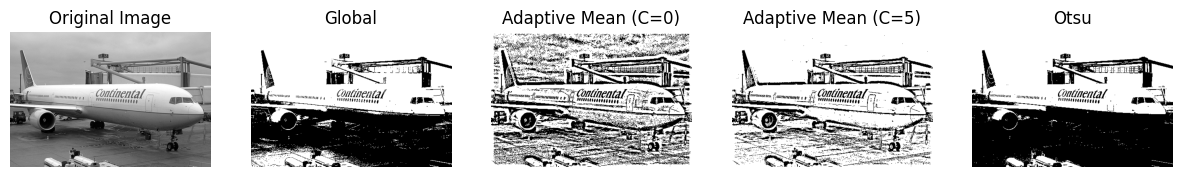

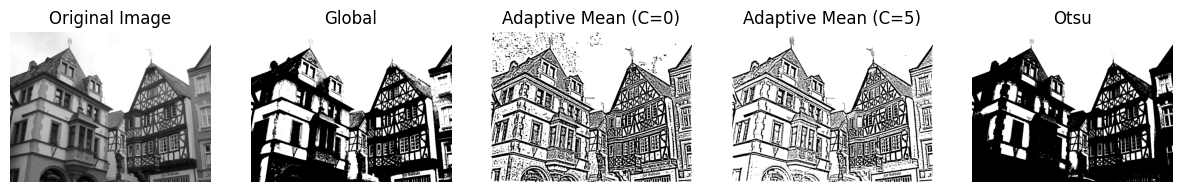

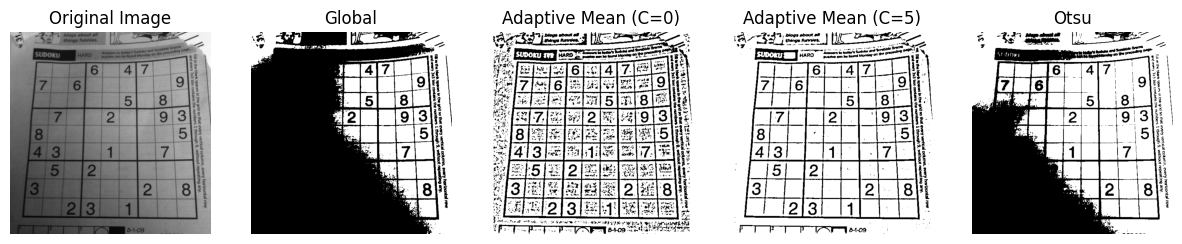

In [ ]:
# Load the local path of test images
images_test_local_path = ["images/aeroplane/2011_002114.jpg", "other images/facade.jpg", "other images/sudoku.jpg"]
images_test_path = []
original_images_test = []

# Load the global path of test images
for local_path in images_test_local_path:
    images_test_path.append(os.path.join(path_images, local_path))

# Load test images in grayscale
for img_path in images_test_path:
    original_images_test.append(cv2.imread(img_path, cv2.IMREAD_GRAYSCALE))

# Set threshold values for testing
global_threshold = 120
adaptive_mean_region_size = 15
adaptive_mean_C = [0, 5]
kernel_size = 15

# Apply thresholding functions
results_thresholding = []
for img in original_images_test:
    result_thresholding = {'Original Image': img}
    result_thresholding['Global'] = global_thresholding(img, global_threshold)
    for C in adaptive_mean_C:
        result_thresholding[f'Adaptive Mean (C={C})'] = adaptive_mean_thresholding(img, adaptive_mean_region_size, C)
    result_thresholding['Otsu'] = otsu_thresholding(img)
    results_thresholding.append(result_thresholding)

# Display functions
def display_images(images_dict):
    plt.figure(figsize=(15, 10))
    for i, (title, img) in enumerate(images_dict.items()):
        plt.subplot(1, len(images_dict), i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.show()

# Display each image in results_thresholding
for result in results_thresholding:
    display_images(result)

### 2. Edge-based Segmentation Exercise
**Objective:**  
Implement edge detectors based in sobel filters, Canny, and Laplacian of Gaussian.


**Guideline:**
1. Load a grayscale image.
2. Compute Sobel filters and the norm to obtain the edges of the image.
3. Implement Canny filter and compare the results to the Sobel results.
4. Implement Laplacian of Gaussian edge detectors.
5. (Optional) Find a method to fill the connected regions to obtain segmented regions (instead of edge regions)

**Expected Results:**  
- Segmented image with the different methods and comparison between them (qualitaively)


In [ ]:
import math as m
def sobel_edge_detection(image):
    """
    Apply Sobel operator to detect edges in an image.

    Parameters:
    image (array_like): The input image for edge detection.

    Returns:
    array_like: The gradient magnitude image representing edges.
    """
    sobel_horizontal = np.matrix([[-1, 0, 1],
                                  [-2, 0, 2],
                                  [-1, 0, 1]])

    sobel_vertical = np.matrix([[-1, -2, -1],
                                [0, 0, 0],
                                [1, 2, 1]])

    numpy_image = np.asarray(image)
    output_image = np.zeros_like(image)
    theta = np.zeros_like(image)


    padded_numpy_image = np.pad(numpy_image, (1,), mode= 'constant', constant_values=0)

    x, y = image.shape

    reversed_sobel_horizontal = np.flip(sobel_horizontal)
    reversed_sobel_vertical = np.flip(sobel_vertical)

    for i in range(x):
        for j in range(y):
            patch = padded_numpy_image[i: i + reversed_sobel_horizontal.shape[0], j: j + reversed_sobel_horizontal.shape[1]]

            gx = np.sum(np.multiply(patch, reversed_sobel_horizontal))
            gy = np.sum(np.multiply(patch, reversed_sobel_vertical))

            output_image[i, j] = m.sqrt(gx**2 + gy**2)
            theta[i, j] = np.arctan2(gx, gy)


    return output_image, theta

def gaussian(image, sigma = 1, size = 3):
    if(not size % 2):
        print("Unnable to process with even-sized kernel")
        return

    numpy_image = np.asarray(image)
    output_image = np.zeros_like(image)

    padded_image = np.pad(numpy_image, (int(size / 2),), mode='constant', constant_values=0)


    a, b = np.meshgrid(np.linspace(-int(size/2), int(size/2), size),
                        np.linspace(-int(size/2), int(size/2), size))
    dst = np.sqrt(a**2+b**2)

    # lower normal part of gaussian
    normal = 1/(2* np.pi * sigma**2)

    # Calculating Gaussian filter
    gauss_kernel = np.exp(-((dst)**2 / (2.0 * sigma**2))) * normal

    #print(gauss_kernel)


    x, y = image.shape

    for i in range(x):
        for j in range(y):
            patch = padded_image[i: i + gauss_kernel.shape[0], j: j + gauss_kernel.shape[1]]
            output_image[i, j] = np.sum(np.multiply(patch, gauss_kernel))

    return output_image


def laplacian(image):
    kernel = np.matrix([[0, -1, 0],
                        [-1, 4, -1],
                        [0, -1, 0]])

    numpy_image = np.asarray(image)
    smooth_image = np.zeros_like(image)

    padded_image = np.pad(numpy_image, (1,), mode= 'constant', constant_values=0)

    x, y = image.shape

    reversed_kernel = np.flip(kernel)

    for i in range(x):
        for j in range(y):
            patch = padded_image[i: i + reversed_kernel.shape[0], j: j + reversed_kernel.shape[1]]
            smooth_image[i, j] = np.sum(np.multiply(patch, reversed_kernel))
            #print(smooth_image[i, j])

    #np.unique(smooth_image)
    return smooth_image

def non_max_suppression(image, theta):
    M, N = image.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = theta * 180. / np.pi
    angle[angle < 0.0] += 180.0


    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255

               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = image[i, j+1]
                    r = image[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = image[i+1, j-1]
                    r = image[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = image[i+1, j]
                    r = image[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = image[i-1, j-1]
                    r = image[i+1, j+1]

                if (image[i,j] >= q) and (image[i,j] >= r):
                    Z[i,j] = image[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass

    return Z

def threshold(image, low, high):
    high_treshold = image.max() * high
    low_treshold = image.max() * low

    output_image = np.zeros_like(image, dtype=np.int64())

    weak = 25
    strong = 255

    strong_i, strong_j = np.where(image >= high_treshold)
    weak_i, weak_j = np.where((image < high_treshold) & (image >= low_treshold))

    output_image[strong_i, strong_j] = strong
    output_image[weak_i, weak_j] = weak

    return output_image, weak, strong

def hysteresis(image, weak, strong):
    m, n = image.shape
    output_image = np.zeros_like(image)

    for i in range(1, m - 1):
        for j in range(1, n - 1):
            if image[i, j] == weak:
                if((image[i - 1, j - 1] == strong) or
                   (image[i - 1, j] == strong) or
                   (image[i - 1, j + 1] == strong) or
                   (image[i, j - 1] == strong) or
                   (image[i, j + 1] == strong) or
                   (image[i + 1, j - 1] == strong) or
                   (image[i + 1, j] == strong) or
                   (image[i + 1, j + 1] == strong)):
                    output_image[i, j] = strong
            elif image[i, j] == strong: output_image[i, j] = strong

    return output_image

def canny_edge_detector(image, low_threshold, high_threshold):
    """
    Apply Canny edge detector to an image.

    Parameters:
    image (array_like): The input image for edge detection.
    low_threshold (int): The lower bound for hysteresis thresholding.
    high_threshold (int): The upper bound for hysteresis thresholding.

    Returns:
    array_like: The binary image representing detected edges
    """

    smooth_image = gaussian(image, sigma=1, size=3)

    gradient_image, theta_image = sobel_edge_detection(smooth_image)

    nonMaxSup_image = non_max_suppression(gradient_image, theta_image)

    threshold_image, weak, strong = threshold(nonMaxSup_image, low_threshold, high_threshold)

    hysteresis_image = hysteresis(threshold_image, weak, strong)

    images = [smooth_image, gradient_image, nonMaxSup_image, threshold_image, hysteresis_image]

    return images

def zero_crossing(image, zero_value):
    x, y = image.shape

    padded_image = np.pad(image, (1,), mode='constant', constant_values=0)
    output_image = np.zeros_like(image)

    for i in range(x):
        for j in range(y):
            if((padded_image[i - 1, j - 1] < zero_value and padded_image[i + 1, j + 1] > zero_value) or
               (padded_image[i, j - 1] < zero_value and padded_image[i, j + 1] > zero_value) or
               (padded_image[i + 1, j - 1] < zero_value and padded_image[i - 1, j + 1] > zero_value)):
                output_image[i, j] = 255

    return output_image


def laplacian_of_gaussian(image, sigma=1, size=3, zero_value = 25):
    """
    Apply the Laplacian of Gaussian edge detector to the image.

    Parameters:
    image (array_like): The grayscale image.
    sigma (float): The standard deviation of the Gaussian kernel.

    Returns:
    array_like: The image with the Laplacian of Gaussian edge detection applied.
    """

    smooth_image = gaussian(image, sigma=sigma, size=size)

    laplacian_image = laplacian(smooth_image)

    zero_image = zero_crossing(laplacian_image, zero_value=zero_value)

    images = list([smooth_image, laplacian_image, zero_image])

    return images




In [ ]:
# Loading grayscale image
image_path = os.path.join(path_images, "images/sofa/2009_000242.jpg")
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Plotting Sobel image
image_sobel, theta = sobel_edge_detection(image)
#plt.imshow(image_sobel, cmap='gray')
#plt.suptitle("Sobel edge detection")
#plt.show()

# Obtaining Canny process images
low_tresh = 0.07
high_tresh = 0.1
canny_images = canny_edge_detector(image, low_tresh, high_tresh)

# Inserting original image at the beggining of the Canny process
canny_images.insert(0, image)

# Obtaining length of process
num_canny = len(canny_images)

# Plotting Canny result
#plt.imshow(canny_images[num_canny - 1], cmap='gray')
#plt.suptitle("Canny edge detection")

# Plotting Canny process
canny_names = ['Original', 'Gaussian', 'Gradient (Sobel)', 'Non-Max Supression', 'Double Threshold', 'Hysteresis']
fig, axs = plt.subplots(1, num_canny, figsize = (num_canny * 10, 10))

for i, canny_image, canny_name in zip(range(num_canny), canny_images, canny_names):
    axs[i].imshow(canny_image, cmap='gray')
    axs[i].title.set_text(canny_name)

fig.suptitle(f"Canny Process: Low = {low_tresh}, High = {high_tresh}")
plt.show()


# Obtaining LoG process images
sigma = 30
kernel_size = 7
zero_value = 120
LoG_images = laplacian_of_gaussian(image, sigma, kernel_size, zero_value=zero_value)

# Inserting original image at the beggining of the LoG process
LoG_images.insert(0, image)

# Obtaining length of process
num_LoG = len(LoG_images)

# Plotting LoG result
#plt.imshow(LoG_images[num_LoG - 1], cmap='gray')
#plt.suptitle("Laplasian of Gaussian edge detection")

# Plotting LoG process
LoG_names = ['Original', 'Laplacian', 'Gaussian', 'Zero Crossing']
fig, axs = plt.subplots(1, num_LoG, figsize = (num_LoG * 10, 10))

for i, LoG_image, LoG_name in zip(range(num_LoG), LoG_images, LoG_names):
    axs[i].imshow(LoG_image, cmap='gray')
    axs[i].title.set_text(LoG_name)

fig.suptitle(f"LoG Process: Sigma = {sigma}, Kernel size = {kernel_size}, Zero-crossing value = {zero_value}")
plt.show()


fig, axs = plt.subplots(1, 3, figsize=(30, 10))
axs[0].imshow(image_sobel, cmap='gray')
axs[0].title.set_text('Sobel')

axs[1].imshow(canny_images[num_canny - 1], cmap='gray')
axs[1].title.set_text('Canny')

axs[2].imshow(LoG_images[num_LoG - 1], cmap='gray')
axs[2].title.set_text('Laplacian of Gaussian')

plt.show()


Output hidden; open in https://colab.research.google.com to view.

*Qualitative comparision:*

Sobel operator works well maximizing the contrast between image contours and flat backgrounds, this can be visualized on the wall and floor of the room in the image, where most of them, where there is not a lot of detail, reduces its intensity to 0, creating defined contours between the painting, the door and the limits of the sofa, however, it remains very sensitive to the noise of the image, as we can identify in the area of the sofa and the cushions, whose texture greatly affects the result of the image by defining shadows that are not desirable in the final result.

Laplacian of Gaussian represents an alternative highly dependent on the defined parameters, although it is the one that defines the contours with greater clarity and continuity, the parameter variation seriously affects the results obtained so that many times we must opt for exchanges that lead us to define only the contours with changes of greater intensities, as can be seen in the image that perfectly highlights certain parts, but we completely lose the detail in other areas, such as the demarcation of the floor or the bottom of the sofa.

Finally Canny is the middle point between the two previous filters, highlighting in a binary way the points whose intensity changes are more noticeable in the image without being too sensitive to noise like the sobel operator, nor omitting important details like LoG. Canny provides an image with contours not as continuous as those obtained from LoG, but we can define figures and perfectly notice the structure of the figures presented having an acceptable balance between the importance given to the perception of noise and the perfect definition of the contours.

### 3. Watersheds

**Objective:**
Implement the watershed algorithm for image segmentation.

**Guideline:**
1. Load a Color Image
2. Preprocessing for Marker Computation. Grayscale it, and find `sure`regions for foreground and background areas.
3. Compute Markers: Label the regions (foreground, background, and unknown) to create markers.
4. Apply Watershed Algorithm. use `cv2.watershed` from OpenCV to perform the segmentation. (Optional: implement your own version of watershed by hand)
5. Visualize the Results and display the segmented image, highlighting the boundaries obtained from the watershed algorithm.

### Expected Results:
- Visual representation of image segmentation using the watershed algorithm. Compare the results qualitatively with the original image.


In [ ]:
def load_color_image(file_path: str) -> np.ndarray:
    """
    Load a color image from the specified file path.

    Parameters:
    file_path (str): The path to the image file.

    Returns:
    np.ndarray: The color image.
    """
    image = cv2.imread(file_path)
    return image

def preprocess_for_markers(image: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Preprocess the image to find sure foreground and background areas.

    Parameters:
    image (np.ndarray): The color image.

    Returns:
    Tuple[np.ndarray, np.ndarray, np.ndarray]: A tuple containing the grayscale image, sure foreground, and sure background.
    """
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Threshold using OTSU
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Opening (Erosion followed by Dilation)
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    # Dilation for Background Identification
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    return gray, sure_bg, opening

def compute_markers(foreground: np.ndarray, background: np.ndarray) -> np.ndarray:
    """
    Compute markers for the watershed algorithm based on the foreground and background.

    Parameters:
    foreground (np.ndarray): The sure foreground area.
    background (np.ndarray): The sure background area.

    Returns:
    np.ndarray: The markers for the watershed algorithm.
    """
    # Distance Transformation
    dist_transform = cv2.distanceTransform(foreground, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.1 * dist_transform.max(), 255, 0)

    # Identify unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(background, sure_fg)

    # Label the sure_bg, sure_fg, and unknown regions
    ret, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0

    return markers

def apply_watershed(image: np.ndarray, markers: np.ndarray, manual: bool = False) -> np.ndarray:
    """
    Apply the watershed algorithm to segment the image.

    Parameters:
    image (np.ndarray): The original color image.
    markers (np.ndarray): The computed markers.
    manual (bool, optional): Flag to perform the watershed algorithm manually. Default is False.

    Returns:
    np.ndarray: The segmented image.
    """
    if manual:
        # Implement your own version of watershed (optional)
        pass
    else:
        # Apply OpenCV's watershed algorithm
        markers = cv2.watershed(image, markers)
        image[markers == -1] = [0, 0, 255]

    return image

def visualize_segmentation(original_image: np.ndarray, segmented_image: np.ndarray):
    """
    Visualize the original and segmented images using matplotlib.pyplot.

    Parameters:
    original_image (np.ndarray): The original color image.
    segmented_image (np.ndarray): The segmented image from the watershed algorithm.
    """
    plt.figure(figsize=(10, 5))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")

    # Segmented Image
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
    plt.title("Segmented Image")

    plt.show()

def watershed_segmentation(image):
    """
    Apply watershed algorithm to segment an image.

    Parameters:
    image (array_like): The input image for segmentation.

    Returns:
    array_like: The segmented image where each region is labeled with a unique integer.
    """
    color_image = load_color_image(image)
    grayscale, sure_background, sure_foreground = preprocess_for_markers(color_image)
    markers = compute_markers(sure_foreground, sure_background)
    segmented_image = apply_watershed(color_image, markers)
    return segmented_image

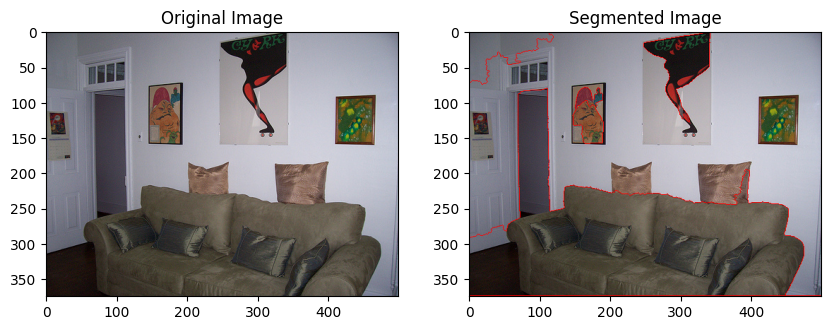

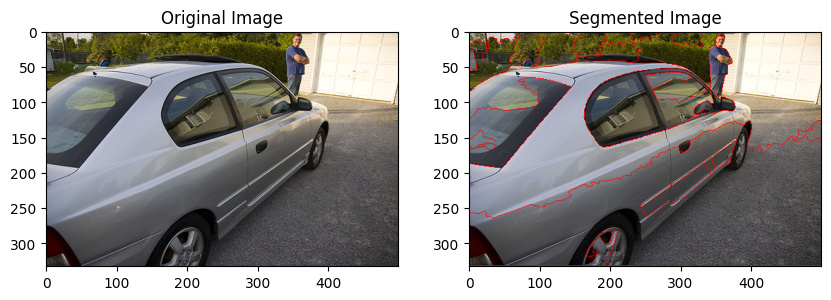

In [ ]:
# Load the local path of test images
images_test_local_path = ["images/sofa/2009_000242.jpg","images/car/2010_003854.jpg"]
images_test_path = []
original_images_test = []

# Load the global path of test images
for local_path in images_test_local_path:
    images_test_path.append(os.path.join(path_images, local_path))

for image_path in images_test_path:
    # Apply watershed segmentation
    segmented_result = watershed_segmentation(image_path)
    # Visualize the original and segmented images
    original_image = load_color_image(image_path)
    visualize_segmentation(original_image, segmented_result)

### 4. Region-Based Segmentation Exercise

**Objective:**  
Explore and implement one region-based segmentation technique. The options are Region Growing, Split-and-Merge, and Flood Fill. These techniques focus on creating image segments based on the similarity and proximity of pixels.

**Guideline:**
1. Choose one of the region-based segmentation methods:
   - **Split-and-Merge (using RAG):** Recursively divides an image into homogeneous regions, then merges adjacent regions with similar characteristics. Represent the image as a Region Adjacency Graph (RAG) using the scikit-image library.
   - **Flood Fill:** Begins from a seed point and expands the region by adding neighboring pixels that match the seed’s properties.

2. Implement the chosen method manually or using appropriate libraries (you can rely on `scikit-image` libraries)
3. Apply the algorithm to a sample image and analyze the results.
4. Perform an analisys of the hyperparameters of the method

**Expected Results:**  
- A segmented image using the selected region-based segmentation method.
- Comparative analysis of the segmented results against the original image to evaluate the effectiveness of the chosen method.


In [145]:
from skimage import data, io, segmentation, color
from skimage import graph
import numpy as np


def _weight_mean_color(graph, src, dst, n):
    """Callback to handle merging nodes by recomputing mean color.

    The method expects that the mean color of `dst` is already computed.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    n : int
        A neighbor of `src` or `dst` or both.

    Returns
    -------
    data : dict
        A dictionary with the `"weight"` attribute set as the absolute
        difference of the mean color between node `dst` and `n`.
    """

    diff = graph.nodes[dst]['mean color'] - graph.nodes[n]['mean color']
    diff = np.linalg.norm(diff)
    return {'weight': diff}


def merge_mean_color(graph, src, dst):
    """Callback called before merging two nodes of a mean color distance graph.

    This method computes the mean color of `dst`.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    """
    graph.nodes[dst]['total color'] += graph.nodes[src]['total color']
    graph.nodes[dst]['pixel count'] += graph.nodes[src]['pixel count']
    graph.nodes[dst]['mean color'] = (graph.nodes[dst]['total color'] /
                                      graph.nodes[dst]['pixel count'])


image_path = os.path.join(path_images, "images/sheep/2008_004854.jpg")
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
compactness = 1
n_segments = 25
thresh = 40
labels = segmentation.slic(img, compactness=compactness, n_segments=n_segments, start_label=0, channel_axis=None)
g = graph.rag_mean_color(img, labels)

labels2 = graph.merge_hierarchical(labels, g, thresh=thresh, rag_copy=False,
                                   in_place_merge=True,
                                   merge_func=merge_mean_color,
                                   weight_func=_weight_mean_color)

out = color.label2rgb(labels2, img, kind='avg', bg_label=0)
out = segmentation.mark_boundaries(out, labels2, (0, 0, 0))

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(img, cmap = 'gray')
axs[0].title.set_text("Original")
axs[1].imshow(out, cmap = 'gray')
axs[1].title.set_text(f"Segmented. Compactness = {compactness}, n_segments = {n_segments}, thresh = {thresh}")

AttributeError: ignored

*Results analysis*

Although the larger intensity changes are performed almost perfectly, as can be seen in the image of the sheep with high intensity values, where even sections of it are defined, the slight intensity changes are difficult to appreciate for this algorithm; this can be seen in the change in the sheep with low intensity values, as well as in the trough area, where the whole food area is together with the wood that delimits it. Although the algorithm is variable according to the given values, so that better configurations could be found, the identification of regions is acceptable, although not in the best way, because, in spite of correctly defining shapes that we expected to be defined, their position and size in the final result is not exactly as expected.

### 5. Cluster-based Segmentation Exercise

**Objective:**  
Analysis between K-means clustering and Gaussian Mixture Models (GMM).
You can use the code or modify at your own.

**Guideline:**
1. Load a color image.
2. Perform an analisys of the hyperparameters of the method
3. Analyze the results and compare the effectiveness of the methods on image segmentation.
4. (Optional) Add extra functionalities to any algorithm

**Expected Results:**  
- Images segmented into distinct regions based on the clustering algorithm.
- In-depth analysis of the segmentation performance, discussing the suitability of the chosen method for the image characteristics.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from skimage.color import rgb2lab, rgb2hsv, hsv2rgb, lab2rgb
from skimage import io

def segment_image_knn(image, color_space='RGB', auto_select_clusters=False, max_clusters=10, init='k-means++', n_init=10, max_iter=300, tol=1e-4, random_state=None):
    """
    Segments the given image using K-means clustering with options for automatic cluster selection and different color spaces.
    """

    # Convert image to the specified color space
    if color_space == 'HSV':
        converted_image = rgb2hsv(image)
    elif color_space == 'Lab':
        converted_image = rgb2lab(image)
    else:
        converted_image = image.copy()  # Copy to avoid modifying the original image

    # Preprocess the image
    image_reshaped = converted_image.reshape((-1, 3))

    # Automatic cluster selection
    if auto_select_clusters:
        best_score = -1
        best_k = 2
        for k in range(2, max_clusters + 1):
            kmeans = KMeans(n_clusters=k, init=init, n_init=n_init, max_iter=max_iter, tol=tol, random_state=random_state)
            labels = kmeans.fit_predict(image_reshaped)
            score = calinski_harabasz_score(image_reshaped, labels)
            if score > best_score:
                best_score = score
                best_k = k
        n_clusters = best_k
    else:
        n_clusters = max_clusters

    # Apply K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, init=init, n_init=n_init, max_iter=max_iter, tol=tol, random_state=random_state)
    kmeans.fit(image_reshaped)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]

    # Reshape the segmented image
    segmented_img = segmented_img.reshape(converted_image.shape)

    # Convert segmented image back to RGB if necessary
    if color_space == 'HSV':
        segmented_img = hsv2rgb(segmented_img)
    elif color_space == 'Lab':
        segmented_img = lab2rgb(segmented_img)
    elif color_space == 'RGB':
        segmented_img = segmented_img.astype(np.uint8)


    return segmented_img

In [ ]:
import numpy as np
from sklearn.mixture import GaussianMixture
from skimage import io, color


def segment_image_gmm(image, color_space='hsv', max_components=10, covariance_type='tied'):
    """
    Segments an image using Gaussian Mixture Models.

    Parameters:
    - resize_factor: int, factor by which the image is resized to reduce computation.
    - color_space: str, color space to convert the image ('rgb', 'hsv', 'lab', etc.).
    - n_components: int, number of components for GMM.
    - covariance_type: str, type of covariance parameters to use.
    - normalization: bool, whether to normalize the image data.

    Returns:
    - segmented_image: np.ndarray, the segmented image.
    """

    # Resize for faster processing
    # Convert to desired color space
    if color_space == 'hsv':
        image_converted = color.rgb2hsv(image)
    elif color_space == 'lab':
        image_converted = color.rgb2lab(image)
    else:
        image_converted = image

    # Reshape the image to be a two-dimensional array
    image_array = image_converted.reshape(-1, 3)

    best_aic = np.inf
    best_n_components = 1

    for n in range(1, max_components + 1):
        gmm = GaussianMixture(n_components=n, covariance_type=covariance_type, random_state=0)
        gmm.fit(image_array)
        current_aic = gmm.aic(image_array)
        #print(f"{n}: {current_aic}")
        if current_aic < best_aic:
            best_aic = current_aic
            best_n_components = n

    # Initialize and fit the GMM
    gmm = GaussianMixture(n_components=best_n_components, covariance_type=covariance_type, random_state=0)
    gmm.fit(image_array)

    # Predict the cluster assignment for each pixel
    segmentation = gmm.predict(image_array)

    # Replace each pixel with the mean color of its segment
    means = gmm.means_
    segmented_image = np.array([means[label] for label in segmentation])

    # Reshape back to the original image shape
    segmented_image = segmented_image.reshape(image.shape[0], image.shape[1], 3)

    # Convert back to RGB if necessary
    if color_space == 'hsv':
        segmented_image = color.hsv2rgb(segmented_image)
    elif color_space == 'lab':
        segmented_image = color.lab2rgb(segmented_image)

    return segmented_image

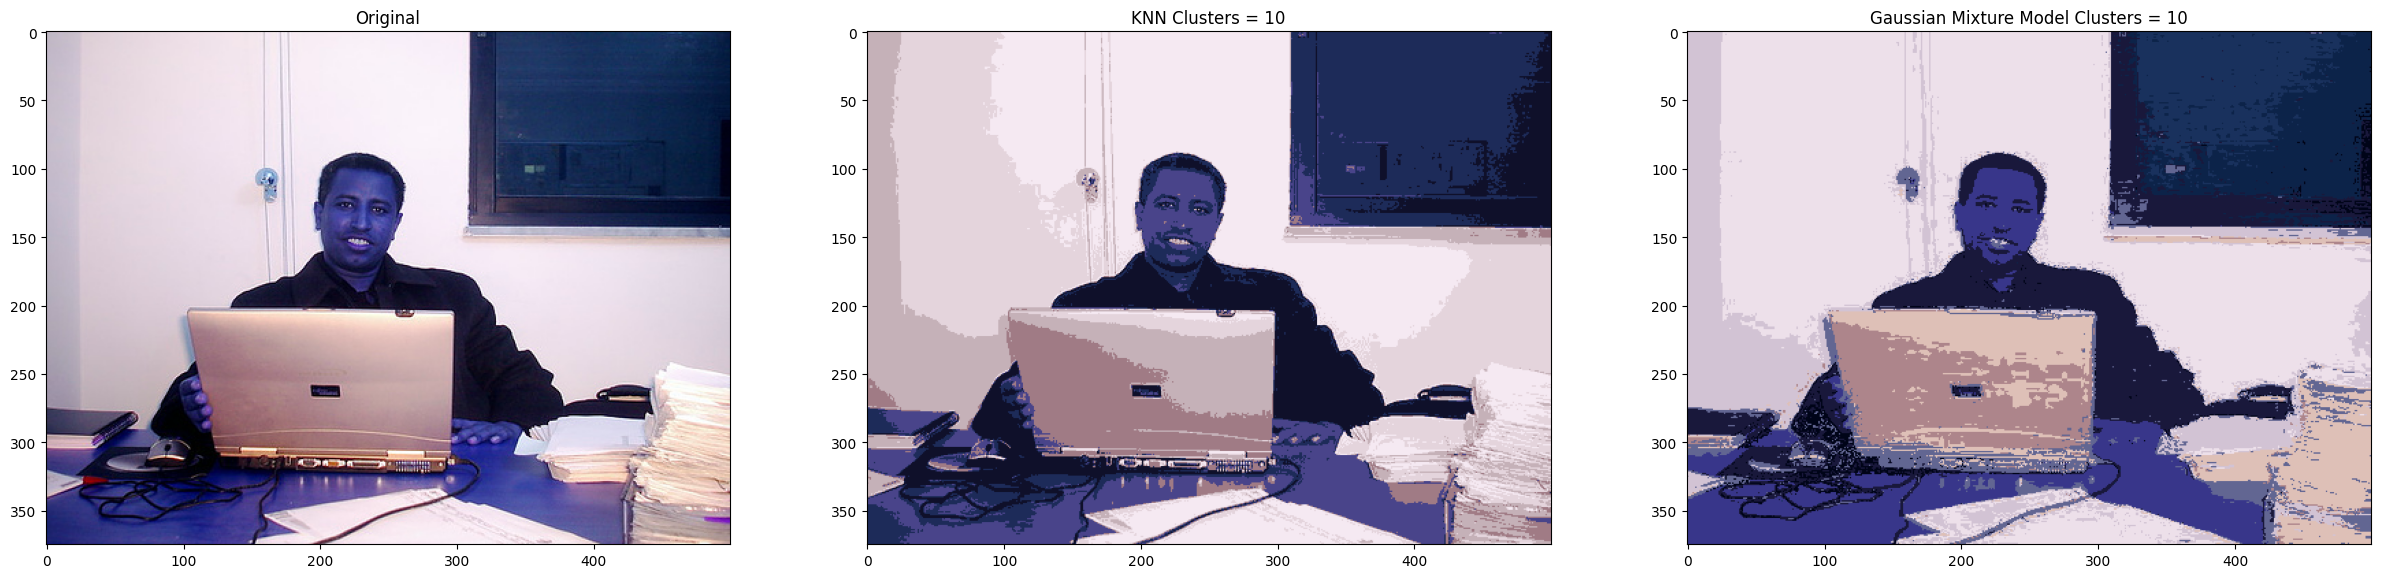

In [ ]:
image_path = os.path.join(path_images, "images/person/2008_001215.jpg")
image = cv2.imread(image_path, cv2.IMREAD_COLOR)

knn_clusters = 10
gmm_clusters = 10

image_kmean = segment_image_knn(image,color_space='RGB', max_clusters=knn_clusters, auto_select_clusters=True)
image_gmm = segment_image_gmm(image, color_space='hsv', max_components=gmm_clusters, covariance_type='full')

fig, axs = plt.subplots(1, 3, figsize = (30, 10))
axs[0].imshow(image)
axs[0].title.set_text("Original")

axs[1].imshow(image_kmean)
axs[1].title.set_text(f"KNN Clusters = {knn_clusters}")

axs[2].imshow(image_gmm)
axs[2].title.set_text(f"Gaussian Mixture Model Clusters = {gmm_clusters}")

plt.show()

*Results analysis*

Given the characteristics of KNN as a model that determines similarity by proximity to the clusters of a given point, we can observe how the segmentation it performs on the image can be affected if the intensities of two objects, ideally segmented as distinct, are similar, because, as it is appreciable in the laptop and the background, the segmentation divides the laptop by sections in its brightness intensity and adds them to the cluster under which the wall was segmented; It is noteworthy how the shape of these clusters is totally circular, highlighting the changes in tonality given by the frontal illumination of the image. We can also observe how the face of the subject is equally affected by the sensitivity to illumination, emphasizing the chin area, which is segmented differently from the rest of the face. The objects on the table may be where it performs best, correctly defining the differences between the table and the objects on it.
In the case of GMM we can find a more regular segmentation where the intensity changes generated by the illumination do not provide too much noise in the final result. This is observable in the background, whose definition is more uniform (highlighting the non-circularity of the generated groupings), and the face and body of the subject, which likewise seem to have less noise. However, in the case of the laptop, although an improvement over knn, the division into several clusters of an object that we would expect to be segmented individually is maintained. The case of the table is satisfactory, although we note a greater difficulty in the segmentation of the stack of sheets on the right if we compare it with KNN.
It is important to mention the longer execution times in the GMM model, which we can interpret as a necessary tradeoff for the uniformity in the segmentation obtained; thus, we consider that knn could be a better option when we have images with little intensity variation due to luminosity issues and few objects in the image, while GMM would work better in images of greater complexity at the cost of high execution costs.